In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Benchmark Model with scikit learn regression
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates
import datetime

# Import utility libraries
import utilities as util

In [32]:
#Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

#Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

#Set Baseline Model Ticker
base_ticker = tick_3

In [33]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     0  1995-01-03   1.228913   25967200
1     1  1995-01-04   1.260937   39670400
2     2  1995-01-05   1.244925   18410000
3     3  1995-01-06   1.344999  269155600
4     4  1995-01-09   1.319479   68521600
---
      Item        Date   Adj_Close    Volume
5147  5147  2015-06-12  122.781413  36886200
5148  5148  2015-06-15  122.540040  43988900
5149  5149  2015-06-16  123.196574  31494100
5150  5150  2015-06-17  122.906931  32918100
5151  5151  2015-06-18  123.466910  35407200


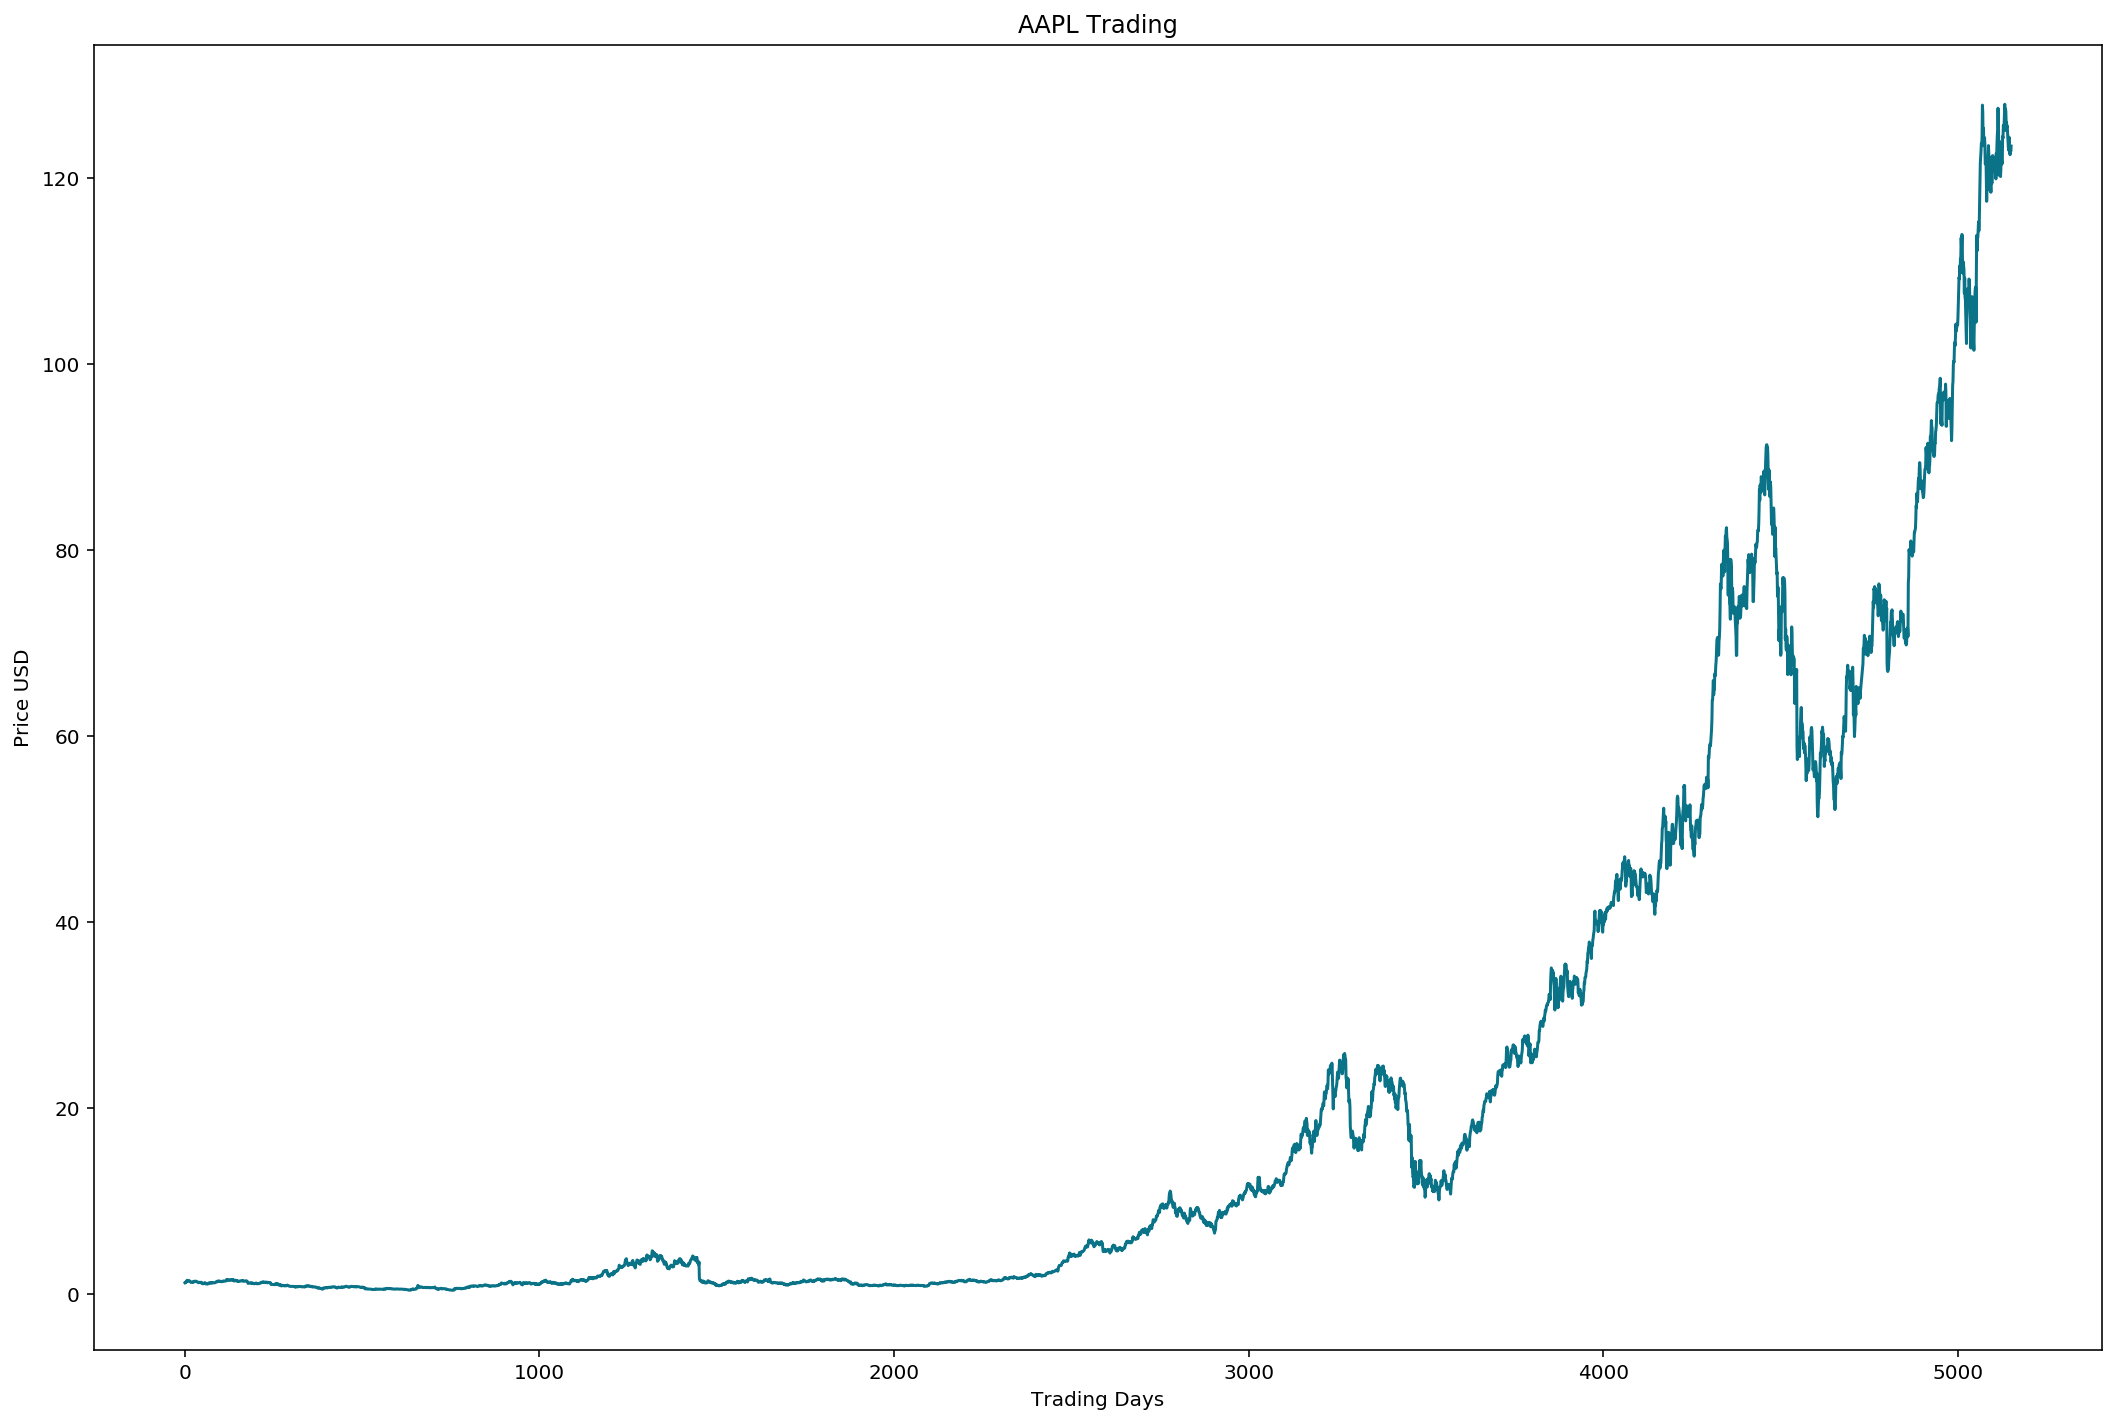

In [34]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.set_title(base_ticker + ' Trading')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

In [35]:
#Create numpy arrays for features and targets
X_all = []
y_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_all.append([(row['Item'])])
    y_all.append([(row['Adj_Close'])])

#pprint(X_all)
pprint(y_all)

[[1.228913],
 [1.260937],
 [1.244925],
 [1.344999],
 [1.319479],
 [1.399039],
 [1.497112],
 [1.45308],
 [1.437068],
 [1.425059],
 [1.441071],
 [1.461085],
 [1.469091],
 [1.365014],
 [1.353005],
 [1.33299],
 [1.312473],
 [1.26494],
 [1.276949],
 [1.2849549999999998],
 [1.292961],
 [1.2849549999999998],
 [1.33299],
 [1.296964],
 [1.296964],
 [1.3069709999999999],
 [1.355007],
 [1.397038],
 [1.401041],
 [1.404898],
 [1.378807],
 [1.366765],
 [1.386835],
 [1.364758],
 [1.31659],
 [1.310569],
 [1.290499],
 [1.252366],
 [1.2282819999999999],
 [1.268422],
 [1.284478],
 [1.284478],
 [1.292506],
 [1.27645],
 [1.230289],
 [1.270429],
 [1.27645],
 [1.268422],
 [1.2242680000000001],
 [1.1239190000000001],
 [1.1239190000000001],
 [1.131946],
 [1.127932],
 [1.131946],
 [1.164058],
 [1.222261],
 [1.192156],
 [1.212226],
 [1.1941629999999999],
 [1.103849],
 [1.103849],
 [1.13596],
 [1.131946],
 [1.139975],
 [1.087793],
 [1.115891],
 [1.1801139999999999],
 [1.1801139999999999],
 [1.1761],
 [1.212226],


In [36]:
# Regularize the feature and target arrays and store min/max of input data for rescaling later
X_bounds = [min(X_all), max(X_all)]
X_bounds = [X_bounds[0][0], X_bounds[1][0]]
y_bounds = [min(y_all), max(y_all)]
y_bounds = [y_bounds[0][0], y_bounds[1][0]]

X_scaled, X_range = util.scale_range(np.array(X_all), input_range=X_bounds, target_range=[-1.0, 1.0])
y_scaled, y_range = util.scale_range(np.array(y_all), input_range=y_bounds, target_range=[-1.0, 1.0])

pprint(y_scaled)
print(y_range)

array([[-0.98730086],
       [-0.98679871],
       [-0.98704978],
       ..., 
       [ 0.92521164],
       [ 0.9206699 ],
       [ 0.92945064]])
[0.41904399999999997, 127.96609099999999]


In [37]:
# Define Test/Train Split 80/20
tt_split = .315
tti_split = int(math.floor(len(stock_df['Item'])*tt_split))

# Set up training and test sets
X_train = X_scaled[:-tti_split]
X_test = X_scaled[-tti_split:]

y_train = y_scaled[:-tti_split]
y_test = y_scaled[-tti_split:]

#pprint(X_train)
#pprint(X_test)

# Create dataframe for all training, testing, and predicted sets
results_df = pd.DataFrame(columns=['Item', 'Actual', 'Actual_Scaled', 'Train', 'Test', 'Test_Scaled', 'Predicted', 'Predicted_Scaled'])
results_df['Item'] = stock_df['Item']
results_df['Actual'] = stock_df['Adj_Close']
results_df['Actual_Scaled'] = y_scaled.flatten()
results_df['Train'][:-tti_split] = y_train.flatten()
results_df['Test'][-tti_split:] = stock_df['Adj_Close'][-tti_split:]
results_df['Test_Scaled'][-tti_split:] = y_test.flatten()

pprint(results_df)


      Item      Actual  Actual_Scaled     Train     Test Test_Scaled  \
0        0    1.228913      -0.987301 -0.987301      NaN         NaN   
1        1    1.260937      -0.986799 -0.986799      NaN         NaN   
2        2    1.244925      -0.987050  -0.98705      NaN         NaN   
3        3    1.344999      -0.985481 -0.985481      NaN         NaN   
4        4    1.319479      -0.985881 -0.985881      NaN         NaN   
5        5    1.399039      -0.984633 -0.984633      NaN         NaN   
6        6    1.497112      -0.983095 -0.983095      NaN         NaN   
7        7    1.453080      -0.983786 -0.983786      NaN         NaN   
8        8    1.437068      -0.984037 -0.984037      NaN         NaN   
9        9    1.425059      -0.984225 -0.984225      NaN         NaN   
10      10    1.441071      -0.983974 -0.983974      NaN         NaN   
11      11    1.461085      -0.983660  -0.98366      NaN         NaN   
12      12    1.469091      -0.983535 -0.983535      NaN        

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
# Create linear regression object
model = linear_model.LinearRegression()

# Train the model using the training sets
model.fit(X_train, y_train)

print(y_range)
# Create the predictions
predictions = model.predict(X_test)
predictions_rescaled, re_range = util.scale_range(predictions, input_range=[-1.0,1.0], target_range=y_range)
print(re_range)
print(predictions)
print(predictions_rescaled)

# Store the predictions
results_df['Predicted_Scaled'][-tti_split:] = predictions.flatten()
results_df['Predicted'][-tti_split:] = predictions_rescaled.flatten()

pprint(results_df)

[0.41904399999999997, 127.96609099999999]
[-0.81169238734175675, -0.69952149786639417]
[[-0.81169239]
 [-0.81162319]
 [-0.81155399]
 ..., 
 [-0.6996599 ]
 [-0.6995907 ]
 [-0.6995215 ]]
[[ 12.42808396]
 [ 12.432497  ]
 [ 12.43691003]
 ..., 
 [ 19.57279074]
 [ 19.57720378]
 [ 19.58161682]]
      Item      Actual  Actual_Scaled     Train     Test Test_Scaled  \
0        0    1.228913      -0.987301 -0.987301      NaN         NaN   
1        1    1.260937      -0.986799 -0.986799      NaN         NaN   
2        2    1.244925      -0.987050  -0.98705      NaN         NaN   
3        3    1.344999      -0.985481 -0.985481      NaN         NaN   
4        4    1.319479      -0.985881 -0.985881      NaN         NaN   
5        5    1.399039      -0.984633 -0.984633      NaN         NaN   
6        6    1.497112      -0.983095 -0.983095      NaN         NaN   
7        7    1.453080      -0.983786 -0.983786      NaN         NaN   
8        8    1.437068      -0.984037 -0.984037      NaN       

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


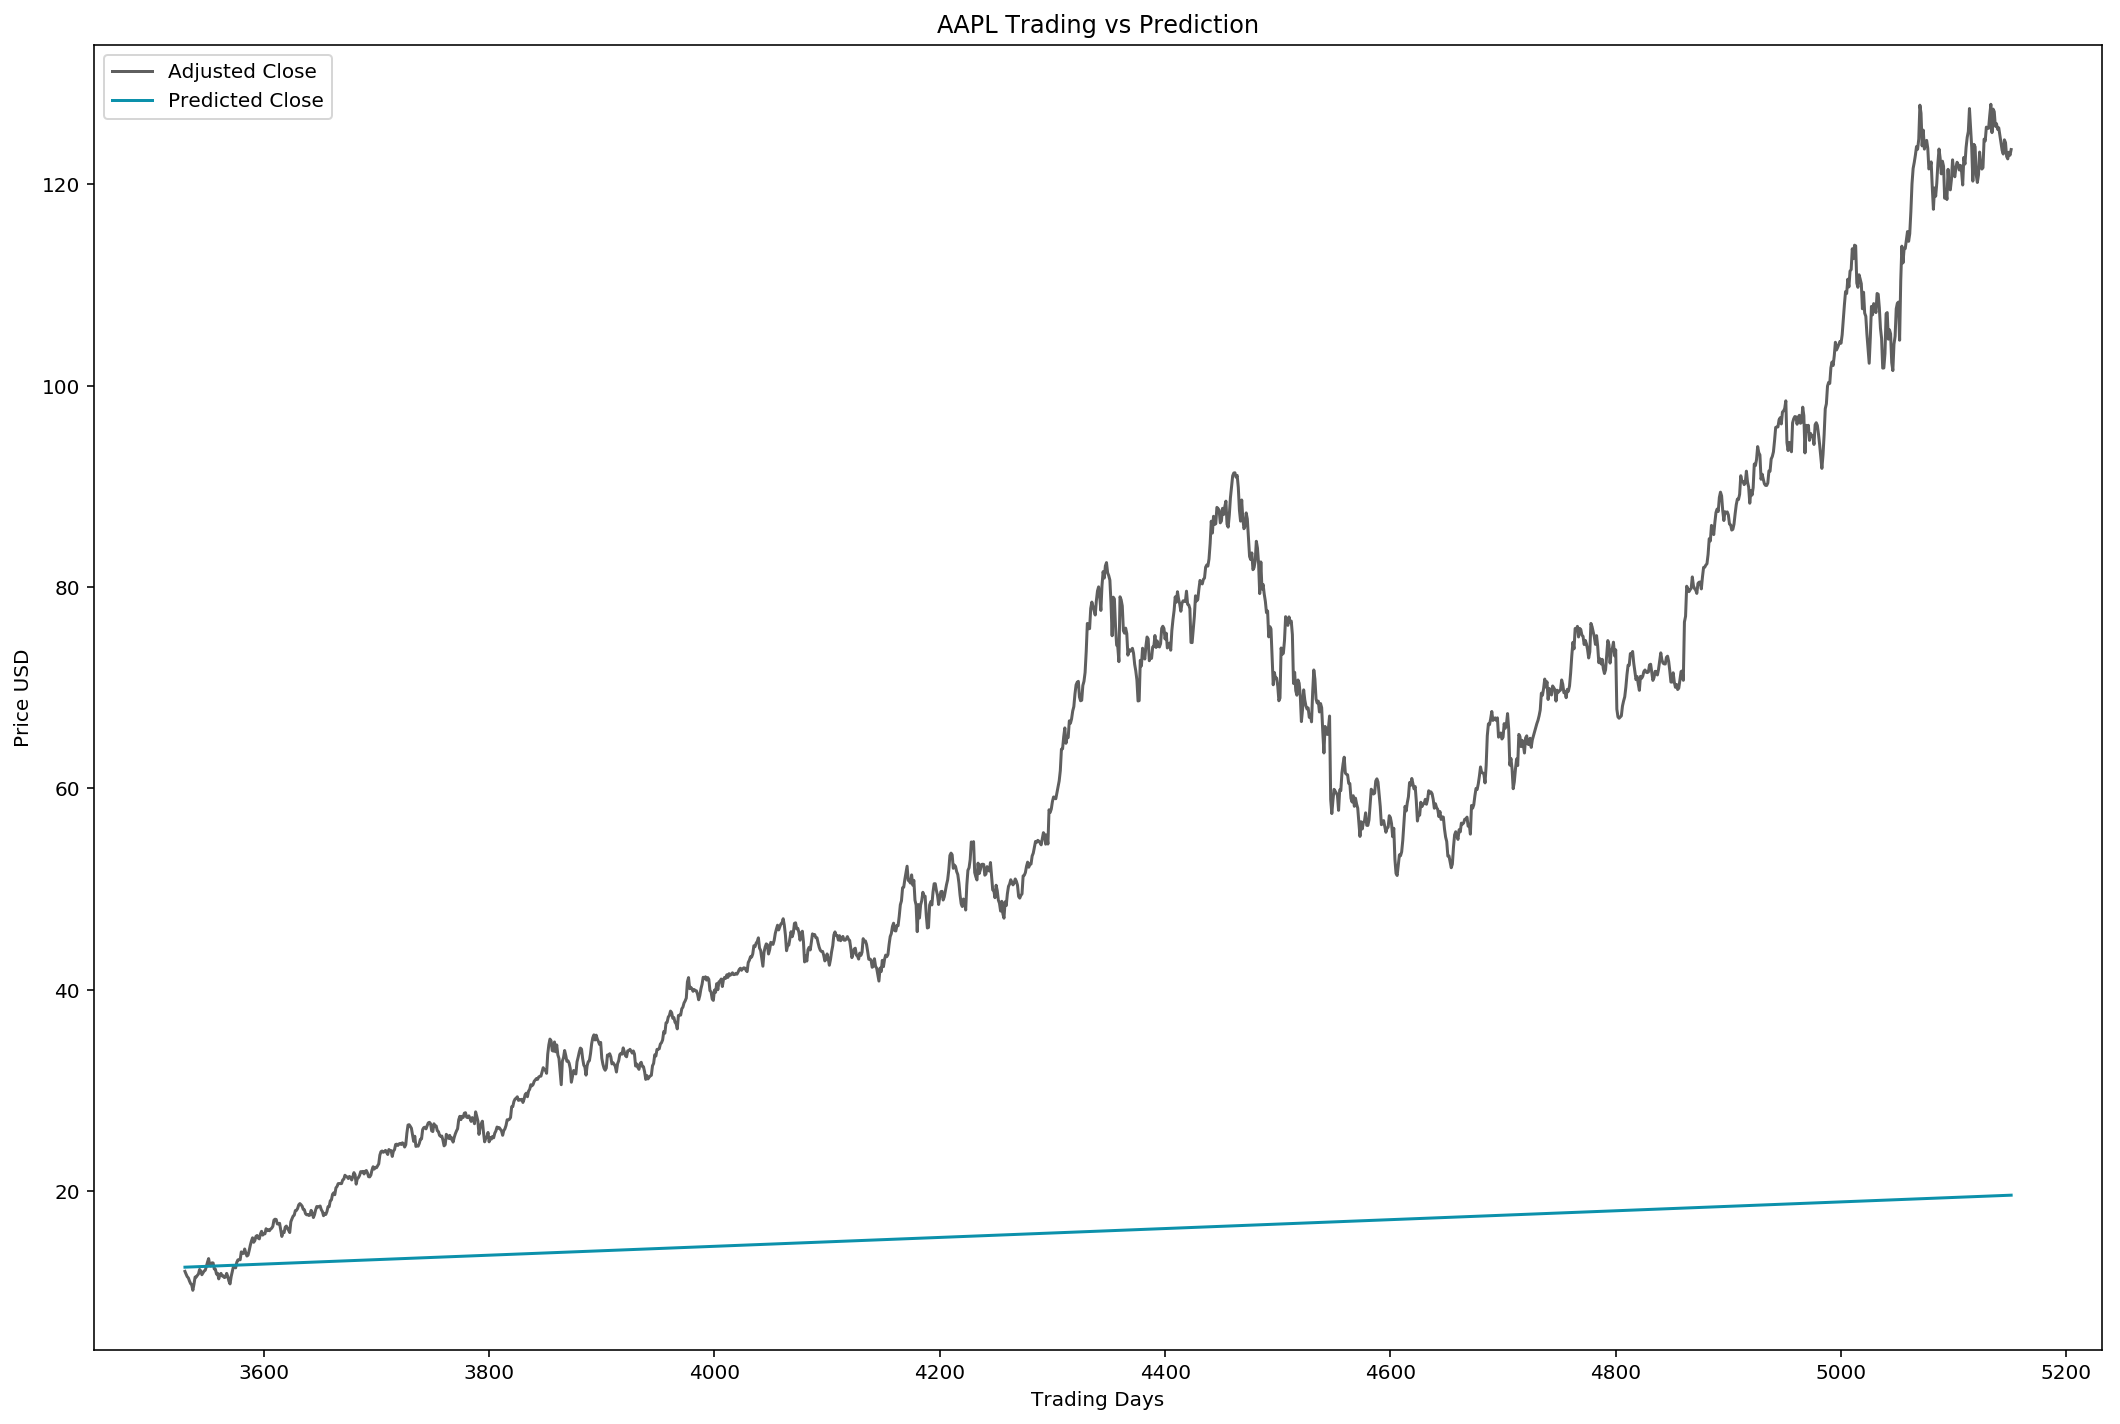

In [39]:
# Plot the training, testing, and predicted data

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(results_df['Test'],'#5F5F5F', label='Adjusted Close')
plt.plot(results_df['Predicted'], '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [40]:
# The mean squared error
testScore = mean_squared_error(predictions, y_test)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.6354 MSE (0.7971 RMSE)


# Log of Results:

### SPY
Test Score: 0.1219 MSE (0.3492 RMSE)

### GE
Test Score: 0.7612 MSE (0.8725 RMSE)

### MSFT
Test Score: 0.0867 MSE (0.2944 RMSE)

### AAPL
Test Score: 0.6354 MSE (0.7971 RMSE)
